# Integer Scheduling Problem

In the [previous problem](02_Linear_Scheduling.ipynb), we solved the scheduling problem using **continuous linear decision variables**.

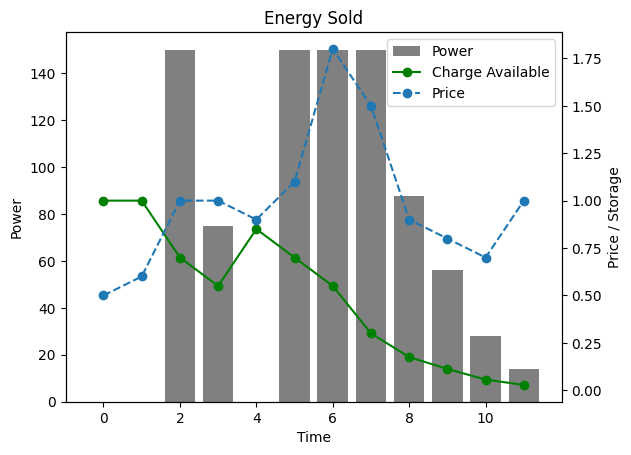

From the results, we observe that power is produced during **9 time periods**, during which the battery is fully utilized.

We now introduce a **new integer (binary) decision variable**.  
The goal is to impose an operational constraint such that the battery must deliver power at at least 50% of $ W^{max}  $ for **a minimum of 8 time periods**.

This transforms the model from a linear program (LP) into a mixed-integer linear program (MILP).



## Introduction to MILP

### What is MILP

**Mixed-Integer Linear Programming (MILP)** extends Linear Programming (LP) by allowing **binary or integer decision variables** in addition to continuous ones.

* LP → continuous variables only
* MILP → continuous variables **+** integer / binary logic

To connect **logic decisions (yes/no, on/off)** with **linear equations**, we often use **Big-M constraints**.

---

### What are Big-M Constraints

A **Big-M constraint** is a modeling technique that allows a constraint to be:

* **enforced** when a binary variable is ON (1)
* **relaxed** when the binary variable is OFF (0)

In simple terms:

> **Big-M constraints are how we connect logic with math.**

---

### Simple Intuitive Example (Coffee ☕)

Let’s say:

* I normally can write **at most 20 lines of code**
* **If I drink coffee**, I can write **at most 10 extra lines**
* Drinking coffee is a **yes/no decision**

---

#### Decision Variables

**Binary variable (logic):**
$ c \in \{0,1\} $

* $c = 1$ → I drink coffee
* $c = 0$ → I do not drink coffee

**Continuous variable (output):**
$ n = \text{total lines of code written} $

---

### Desired Logic (in words)

* If I **don’t drink coffee**, then
  $ n \leq 20 $
* If I **drink coffee**, then
  $ n \leq 30 $

### Other Constraints
* Non-Negativity
  $ n \geq 0 $

---

### Mathematical Formulation (Big-M Constraint)

We use a **large constant (M)** (called *Big-M*):  
Big-M is not always a huge number.
> Big-M = the largest value needed to fully relax a constraint (i.e. turn off the constraint)

So:
in this example → M = 10

$ n \leq 20 + 10c $

Why this works:

| Coffee (c) | Constraint becomes | Result           |
| ---------- | ------------------ | ---------------- |
| 0          | $n \leq 20$         | no extra lines   |
| 1          | $n \leq 30$         | bonus unlocked ☕ |

The binary variable **turns on/off** the extra capacity.

**What does it mean to "relax the constraint":**
> A constraint is fully relaxed when it is guaranteed not to restrict the variable anymore.

#### General Rule in Choosing the M
If $ M $ is:
* Too small -> constraint still restricts (wrong logic)
* Too large -> solver becomes slow/unstable
* Just right -> clean logic + fast solver

---

### Objective Function (optional)

If we want to **maximize productivity**:

$ \max n$

The solver will choose:

* $c = 1$ (drink coffee)
* $n \leq 30$

**Note:**
> Notice how the objective **does not** reference the binary variable directly;  
> instead, the binary variable affects the feasible region through constraints
---

### Why This is Called “Big-M”

* $M$ is a **large value** needed to fully relax a constraint
* When the binary is OFF → constraint is relaxed/off
* When the binary is ON → constraint is enforced/on (may become binding)

---

TLDR

> Big-M constraints allow binary variables to activate or deactivate linear constraints, enabling logical decisions inside MILP models.
